In [28]:
import os
import numpy as np

import torch
import torchvision.datasets as dset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import math
from torch.autograd import Variable
from torch.utils.data import sampler
import torch.nn.functional as F
from skimage import io, transform


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

import timeit, random
import json,cv2
import show

%load_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def convert_coordinates(origin, point):
    new_x = point[0] - origin[0]
    new_y = origin[1] - point[1]
    return (new_x, new_y)

def calculate_origin(width, height):
    new_width = width//2
    new_height = height//2
    return (new_width, new_height)

def revert_coordinates(origin, point):
    orig_x = point[0] + origin[0]
    orig_y = origin[1] - point[1]
    return (orig_x, orig_y)

def reflect_across_y(point, width):
    array_x = width - 1
    old_x = point[0]
    old_y = point[1]
    return (array_x-old_x, old_y)

def reflect_across_x(point, height):
    array_y = height - 1
    old_x = point[0]
    old_y = point[1]
    return (old_x, array_y - old_y)

def flip_h(img, joints):
    n_image = T.functional.hflip(img)
    new_joints = []
    for i in joints:
        point = (i[0], i[1])
        r_point = reflect_across_y(point, img.size[0])
        new_joints.append([r_point[0], r_point[1]])
    return n_image, new_joints

def flip_v(img, joints):
    n_image = T.functional.vflip(img)
    new_joints = []
    for i in joints:
        point = (i[0], i[1])
        r_point = reflect_across_x(point, img.size[1])
        new_joints.append([r_point[0], r_point[1]])
    return n_image, new_joints

def zoom_in(img, joints):
    pass

def resize(img, joints):
    new_size = random.randint(100, 200)
    n_image = T.functional.resize(img, 224)
    new_width = n_image.size[0]
    new_height = n_image.size[1]
    p_width = new_width/img.size[0]
    p_height = new_height/img.size[1]
    new_joints = []
    for i in joints:
        new_x = int(p_width * i[0])
        new_y = int(p_height * i[1])
        new_joints.append([new_x, new_y])
    return n_image, new_joints

def rotate(img, joints):
    origin = calculate_origin(img.size[0],img.size[1])
    
    n_image = T.functional.rotate(img, 45)
    new_joints = []
    for i in joints:
        point = (i[0],i[1])
        converted_point = convert_coordinates(origin, point)
        radian = math.radians(45)
        new_x = converted_point[0] * math.cos(radian) - converted_point[1] * math.sin(radian)
        new_y = converted_point[1] * math.cos(radian) + converted_point[0] * math.sin(radian)
        
        new_point = (int(new_x),int(new_y))
        final_point = revert_coordinates(origin, new_point)
        new_joints.append([final_point[0], final_point[1]])
        
    return n_image, new_joints

In [42]:
# Dataset class for memory efficient data processing 
class HandGestureDataset(torch.utils.data.Dataset):
    """ Hand Gesture Dataset """

    def __init__(self, root_dir, transform=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.joints = json.load(open(self.root_dir+"scaled_annotations.json","r"))
        self.names = list(self.joints)
        self.trans = [flip_h, flip_v,rotate]
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.names))
        name = self.names[idx]
        image = Image.open("Dataset/ColoredProcessedImages/" + self.names[idx] + ".png")
        temp = []
        for i in range(len(self.joints[name])):
            temp.append([int(self.joints[name][i][0]), int(self.joints[name][i][1])])
        s_image, s_temp = resize(image, temp)
        n_image, n_temp = self.trans[random.randrange(0, len(self.trans))](s_image,s_temp)
        r_image = np.array(n_image)
        temp = []
            
        sample = {'image': r_image, 
                  #'joints': temp,
                  'joints': n_temp,
                  'name' : name
                 }

        if self.transform:
            sample = self.hog(sample)

        return name, r_image, n_temp
    
    def substract_mean(self, sample):
        sample['image'] = sample['image'].astype(np.float64) - np.mean(sample['image']).astype(np.float64)
        return sample
    
    def hog(self, sample):
        
        sample['image'] = cv2.Laplacian(sample['image'], cv2.CV_64F)
#         sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 1, 0, ksize=5)
#         sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 0, 1, ksize=5)
        return sample
        

In [43]:
# DataLoader class to create a muli-process iterator and load data into memory faster
data = HandGestureDataset("Dataset/", transform=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=5, shuffle=True, num_workers=6)

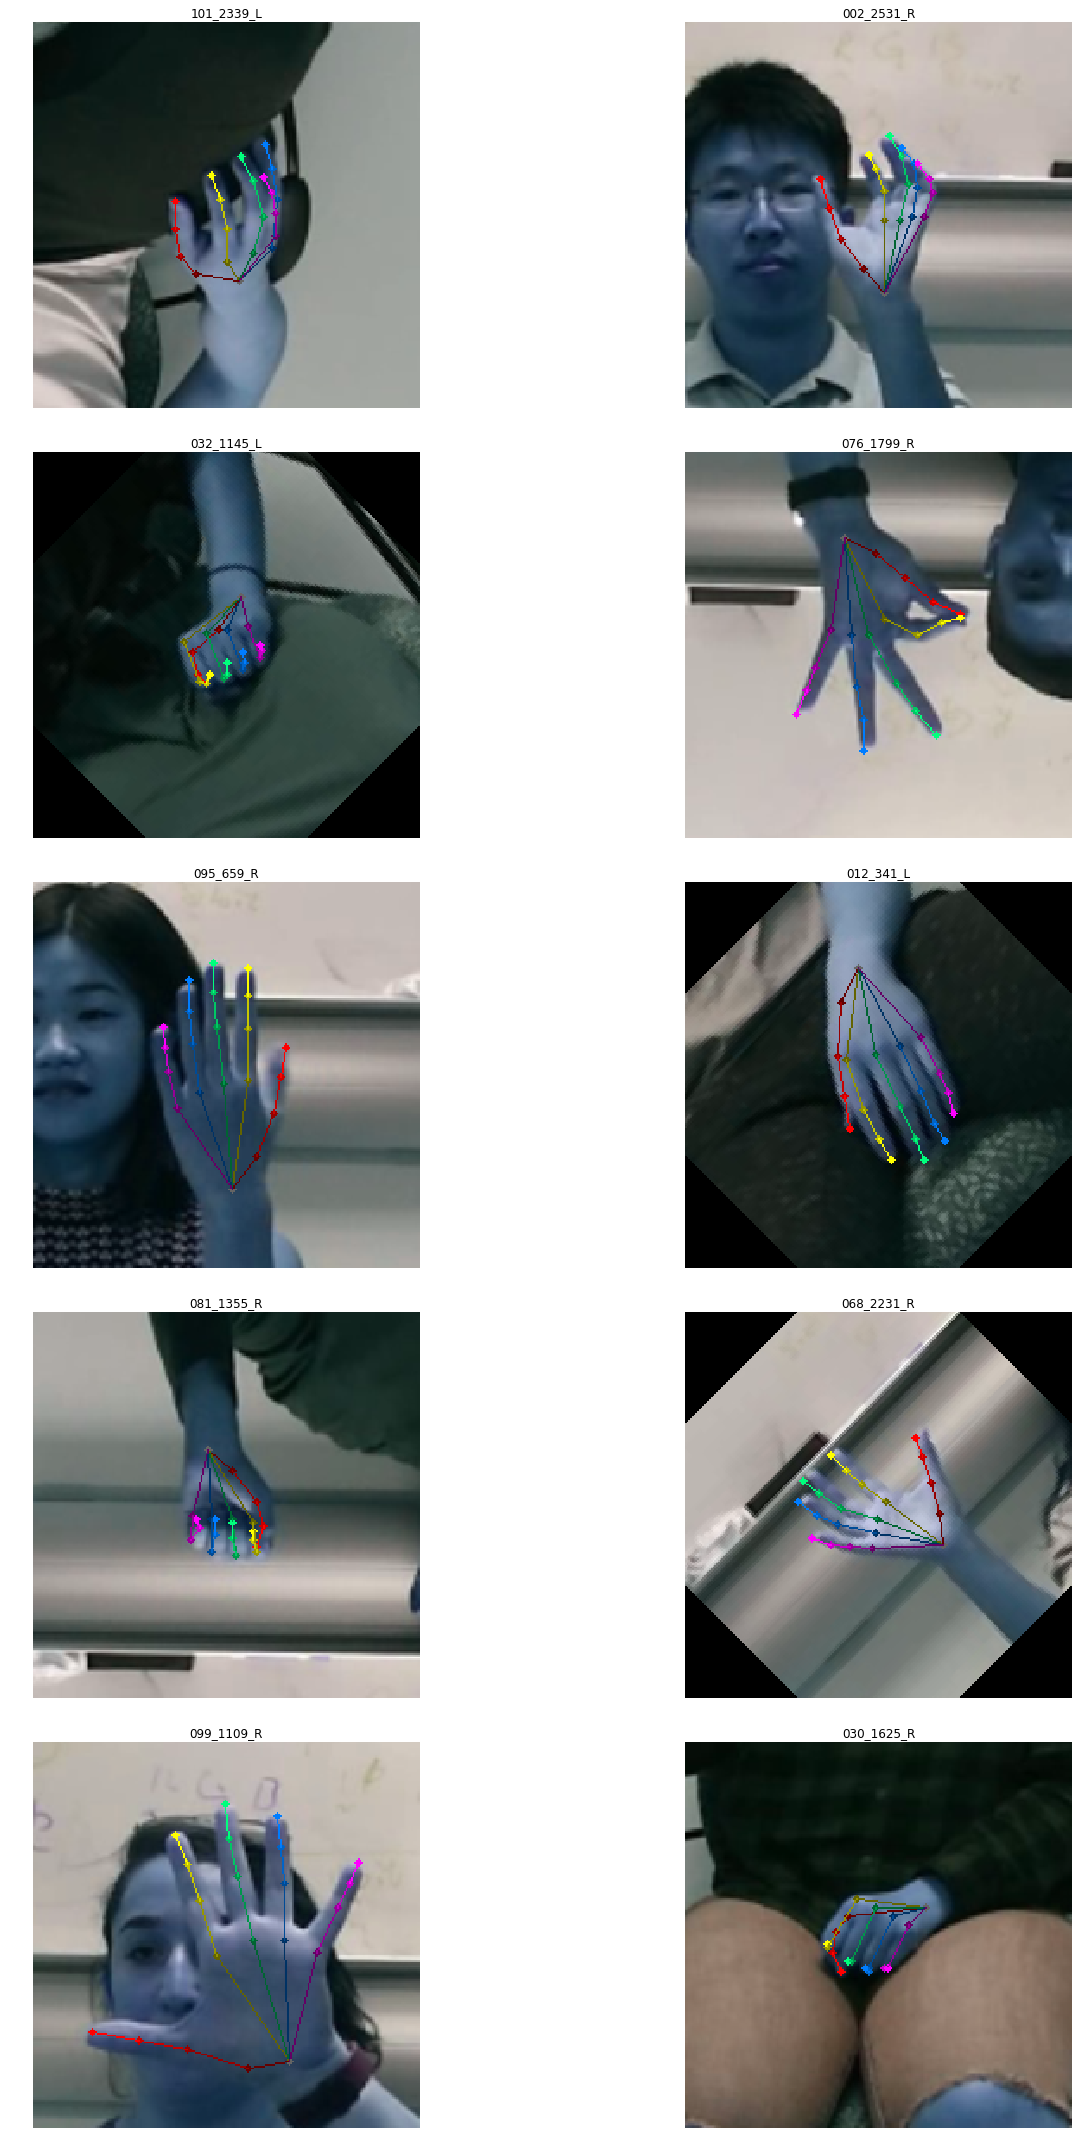

In [45]:
num = 10
fix, ax = plt.subplots(num//2, 2, figsize=(20, num*3))
ax = [a for b in ax for a in b] # wooooo


for i in range(len(data)):
    sample = data[i]
    
    plt.tight_layout()
    ax[i].set_title(sample[0])
    ax[i].axis('off')
    canvas = show.draw_hand(sample[1], sample[2])
    ax[i].imshow(canvas)

    if i == num-1:
        plt.show()
        break

In [73]:
import copy
torch.cuda.empty_cache()
gpu_dtype = torch.cuda.FloatTensor
model = models.resnet18(pretrained=True)
model = model.cuda()
ct = 0
for name, child in model.named_children():
    ct += 1
    if ct == 10:
        for name2, params in child.named_parameters():
            params.requires_grad = False
print(ct)

10


In [81]:
import copy
torch.cuda.empty_cache()
gpu_dtype = torch.cuda.FloatTensor
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 42)
model = model.cuda()
a = enumerate(dataloader)
x_var = 0
model.train()
for i,(name,x,y) in a:
    x_var = Variable(x.type(gpu_dtype))
    N, C, H, W = x_var.size() # W is C
    x_var =  x_var.view(N, W, C, H)
    scores = model(x_var)
    print(scores.size())
    break
torch.cuda.empty_cache()

torch.Size([5, 42])
